In [2]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from scripts.utils import *

In [4]:
df = pd.read_csv("data/concatenated/X_balanced.csv")
x_train,y_train,x_val,y_val,x_test,y_test,class_weight = split_and_shuffle(df)

Examples:
    Total: 224092
    P: 80056 (35.72% of total)
    S: 64346 (28.71% of total)
    W: 79690 (35.56% of total)

Weight for class 0: 1.40
Weight for class 1: 1.74
Weight for class 2: 1.41


In [5]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

y_test = test_df.pop('Class')
x_test = test_df
y_train = train_df.pop('Class')
x_train = train_df
y_val = val_df.pop('Class')
x_val = val_df

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)
x_test = scaler.fit_transform(x_test)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

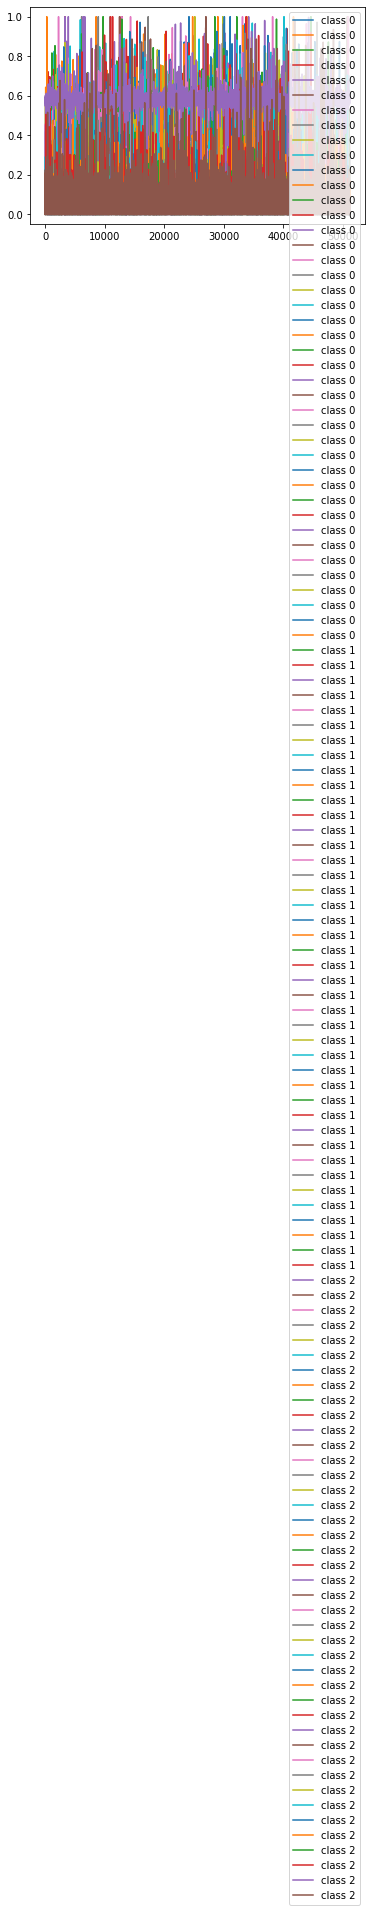

In [6]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train, label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

In [7]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [8]:
num_classes = len(np.unique(y_train))
num_classes

3

In [9]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [10]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=10, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=10, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=10, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


2021-10-12 13:23:48.209495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-12 13:23:48.209535: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-12 13:23:48.209563: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (RNA): /proc/driver/nvidia/version does not exist
2021-10-12 13:23:48.209899: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
epochs = 500
batch_size = 100

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss",verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    x_train,
    tf.one_hot(y_train,depth=3),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(x_val, tf.one_hot(y_val,depth=3)),
    verbose=1,
)

2021-10-12 13:23:56.011807: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-12 13:23:56.031142: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3997640000 Hz


Epoch 1/500
 718/1435 [==============>...............] - ETA: 14s - loss: 0.4780 - categorical_accuracy: 0.8208

KeyboardInterrupt: 

In [101]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, tf.one_hot(y_test,depth=3))

print("Test accuracy", test_acc)

print("Test loss", test_loss)

1401/1401 [==============================] - 3s 2ms/step - loss: 0.4199 - categorical_accuracy: 0.8502
Test accuracy 0.850175142288208
Test loss 0.41989821195602417


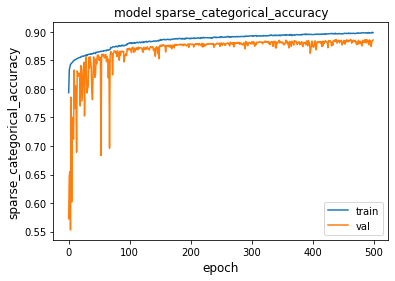

In [74]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()